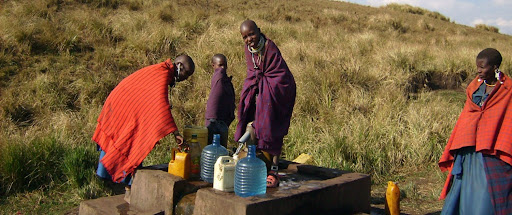

# Modeling Water Wells in Tanzania
---

**Authors**: [Kelsey Lane](https://github.com/kelsklane), [Andy Schmeck](https://github.com/andrewschmeck), and [Ted Brandon](https://github.com/theobigdog)

Date:  10/29/2021

## Overview
---
This project uses data about Tanzanian wells available at [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/). Our model seeks to classify wells as functional or not in order to help a non-government organization (NGO) determine which wells they need to repair. After the data were cleaned, various iterative classification models were run in order to identify a model that has the best mix of a high precision and low complexity. We found that the amount of total static head (tsh) of the well, alongside its installer, extraction type, and if it had a government permit, were all significant predictors in classifying the functionality of a well with 75% precision.

## Business Understanding
---
An NGO seeks to help Tanzania accomplish its' Millenium Development Goal 7C: "halving the proportion of the population without sustainable access to safe drinking water," ([MDG report](https://commonwealthfoundation.com/wp-content/uploads/2013/10/MDG%20Reports%20Tanzania_FINAL_2.pdf)). Tanzania's situation is dire ([World Bank](https://reliefweb.int/sites/reliefweb.int/files/resources/120166.pdf![image.png](attachment:image.png))): 

- Only 60% of Tanzanians get their drinking water from an improved source
- As of 2014, of the 83,000 rural water points recorded in the national water point census only 40% were found to be non-functional, with the likelihood of failure highest at 20% during their first year of operation

Improving water supply, sanitation, and hygeine conditions have been linked with improved human development, reduced poverty, and reduced stunting in early childhood ([World Bank](https://reliefweb.int/sites/reliefweb.int/files/resources/120166.pdf![image.png](attachment:image.png))) meaning this is a very important focus for Tanzania.

46% of the wells in Tanzania are in need of repair or nonfunctioning. Instead of building new wells, an NGO can drastically increase clean water supply by simply fixing wells. The urgency of the situation, and an NGO's financial constraints, increase the need for precision in our model. Sending an NGO out to a fully-functional well would be expensive and cost the opportunity of fixing an actual nonfunctioning well.  This problem may be exacerbated since some of these wells are very remote and in mountainous regions, hence the focus on precision for evaluating the model. By using our precise model, the NGO can preemptively address probable pump failures and increase the sustainable, improved well capacity of Tanzania.

## Data Understanding and Preperation
---
The data used in this analysis is provided by [Tanzania's Ministry of Water](https://www.maji.go.tz/) and compiled by [Taarifa](https://taarifa.org/) available at [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/). The dataset includes information of 59,400 wells, each of which has 41 different features. The target column, `status_group`, indicates if the well is *functional*, *in need of repair*, or *non-functional*. We are able to use the features provided about each well to build a classification model to predict the status of the well, and thus help the NGO determine which wells of unknown status may or may not need repairs.

In [1]:
#Import needed modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from pandas.core.common import SettingWithCopyWarning

#Bring together the features and target for easier engineering
df_feat = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
df_targ = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
df = pd.concat([df_feat, df_targ], axis = 1)

#Filter out copy warnings for readability
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Column Inclusion

The dataset has many columns that represent the same information at different levels of specificity. To help illustrate this, the columns in the original dataset are listed out below.

In [2]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'id', 'status_group'],
      dtype='object')

As you can see, there is a lot of overlap, such as `waterpoint_type` and `waterpoint_type_group`, or `extraction_type`, `extraction_type_group`, and `extraction_type_class` (an explanation of all features can be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/)). These would pose multicollinearity issues, as, it's the same information represented at different levels, so for all overlaping columns, the most general ones were kept in order to reduce dimensionality in the data. For insurance, each column was analyzed with a $\chi^2$ test to ensure true relation, with an example shown below:

In [2]:
# Import relevant module
from scipy.stats import chi2_contingency

#Run the test and check the p-value to see if it's below 0.05
chi2, pval, dof, expected = chi2_contingency(pd.crosstab(df['extraction_type'], df['extraction_type_class']))
pval

0.0

Furthremore, there are other columns which have unclear or ambiguous content. For example, `num_private` is a column with no description given by the DrivenData site, and it is not obvious what this feature indicates. A similar idea holds for `public_meeting`. As a result, these features were dropped. Other unnecessary columns that were dropped include `id`, as it is just the unique identifier for each row, `recorded_by`, as it is the same entry for every row, and `funder`, as it does not seem likely that the funder of the well had any impact on its future functionality. This left us with the following dataset.

In [2]:
#Drop the excess columns
df_trim = df.drop(columns = ['id', 'extraction_type', 'extraction_type_group', 'scheme_name',
                            'payment', 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group',
                            'region_code', 'district_code', 'ward', 'subvillage', 'lga', 'num_private',
                            'recorded_by', 'funder', 'public_meeting', 'wpt_name'], axis = 1)
#Display remaining columns
df_trim.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'population', 'scheme_management',
       'permit', 'construction_year', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity',
       'source', 'source_class', 'waterpoint_type', 'status_group'],
      dtype='object')

As it is unclear from the remaining columns which features may or may not be significant in predicting well failure, the rest of the columns are left in for the time being. These will be paired down later, using a decision tree to find the most significant indicators. The columns remaining, though, all seem different from each other and good potential predictors. The continuous variables were checked against each other using a heatmap to see if there was any multicolinearity, of which there was none. Two important notes: 1) despite the similar column names, `source` and `source_class`, as well as `management` and `management_group` appear to represent different pieces of information, and thus 2) are retained depsite the similar column names.

### Data Cleaning

One issue in the remaining data has to do with `longitude` and `latitude`. Tanzania does not include null island (0$^{\circ}$ 0$^{\circ}$), but there are occurances of these coordinates in the data. As a result, the rows containing these points were dropped, as they represent only 3\% of the data and the model is only predicting well functionality inside of Tanzania.

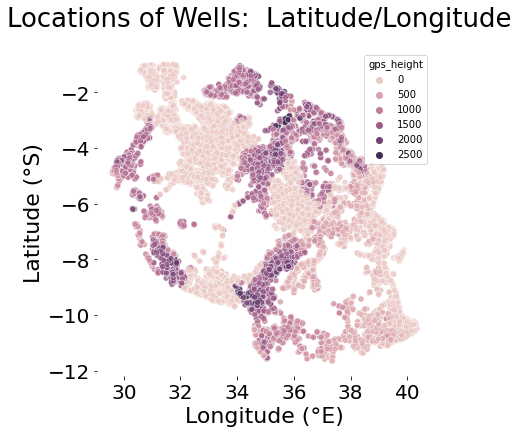

In [10]:
#Drop bad longitude/latitude rows
df_trim = df_trim[df_trim['longitude'] != 0]

#Display updated coordinates to check for any other anomalies
fig, ax = plt.subplots(figsize=(6,6))
df2 = df[df['latitude'] != 0]
df3 = df2[df2['longitude'] != 0]
sns.scatterplot(x = df3['longitude'], y = df3['latitude'], hue = df3['gps_height'],
                marker='o', alpha=0.75)
sns.despine(left=True,bottom=True)
plt.suptitle('Locations of Wells:  Latitude/Longitude', fontsize=26)
plt.xlabel('Longitude (°E)', fontsize=22)
plt.ylabel('Latitude (°S)', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);


The `permit` column indicates if the well is or is not government approved. We elected to fill the missing values in this column with *False* rather than the mode value of *True*, because we did not want to assume government approval from data that are from the government. As a result, these are filled ahead of time before the train-test split.

In [4]:
#Fill the nulls in "permit" with False
df_trim['permit'] = df_trim['permit'].fillna(value = False)

There are 18,897 zero values in `construction_year`, which represent null values. As this is a high proportion of the column and we didn't want to simply impute the value with another, we instead opted to bin the column into decades and replace the zeroes with 
*Unknown*.

In [5]:
#Bin years into decades
def decades(year):
    #Returns unknown if value not recorded
    if year == 0:
        return 'Unknown'
    else:
        return str((year // 10) * 10)
#Apply mapping to column
df_trim['construction_year'] = df_trim['construction_year'].apply(decades)

Finally, `scheme_management` and `installer` both have null values remaining. As they also have a large number of unique entries, these columns were binned into the top five most frequent values and *other*. The null values were filled with *other* as well. Since we did not want to risk data leakage, this process was performed after the trian-test split in order to obtain frequencies based only on the training data.

### Feature Creation

The season in which the well data was recorded may affect the funcitonality of the well, as, intuitively, wells recorded during a rainy season may have more water depending on their source. We elected to add a `season` column based on `date_recorded` and then dropped `date_recorded`.

In [6]:
#Grab the month
df_trim['month'] = pd.DatetimeIndex(df_trim['date_recorded']).month

#Make dictionary to map month to season
season = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 
          8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}

#Apply transformation and drop month and date_recorded
df_trim['season'] = df_trim['month'].map(season)
df_trim = df_trim.drop(columns = ['month', 'date_recorded'], axis = 1)

### Consolidating the Target

In the original dataset, `status_group` is a column containing *functional*, *non functional*, and *functional needs repair*. We are engineering this problem to be binary, so *non functional* and *functional needs repair* were collapsed into one column, as, these are the wells the NGO would want to identify as in need of attention/maintenance. The binary classification eliminates the issues with class imbalance, present in the original distinction, leaving the classes now relatively even with 54% of the wells being functional and 46% needing some attention.

In [7]:
#Map the columns to the binary target 0 or 1
df_trim.status_group = df_trim.status_group.map({'functional' : 0, 'non functional': 1, 'functional needs repair': 1})

### Limitations

Both `amount_tsh` and `population` have high zero-counts. While zero is a valid potential entry for these columns, it has also been used to represent null values throughout the dataset. Therefore, it is not clear how many of these zeroes represent actual zeroes and how many represent nulls. These columns are also the only ones with outliers that are unaccounted for. However, due to the heavy skew that the zeroes add to the data, it isn't clear where to draw the cutoff for outliers. Therefore, this gums up the data and makes the results of using these columns unclear. 

We were also limited in our ability to utilize two specific columns, as, we did not know what kind of data was recorded:  `num_private` and `public_meeting`. 

Lastly, we were limited to the timeframe the data were collected, between 2003-2013, which could impact our predictive abilities.

## Modeling
---
Because there is minimal class imbalance present in the data, we opted to use a DummyClassifier to create a baseline model based on the most frequent label.

In [8]:
#Import all the needed modules
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

#Bin installer column on training frequency
def install_bin(entry):
    #Bins nulls as other
    if type(entry) == float:
        return 'other'
    #Checks lowercase to account for mistyped entries
    elif entry.lower() in inst_list:
        return entry.lower()
    else:
        return 'other'

#Bin scheme_management based on training frequency
def scheme_bin(entry):
    if type(entry) == float:
        return 'other'
    elif entry.lower() in scheme_list:
        return entry.lower()
    else:
        return 'other'

In [9]:
#Create X and y dataframes and train-test split them
y = df_trim['status_group']
X = df_trim.drop(columns = ['status_group'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#Bin and fill in nulls in installer
inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()
X_train['installer'] = X_train['installer'].apply(install_bin)
X_test['installer'] = X_test['installer'].apply(install_bin)
      
#Bin and fill in nulls in scheme_management
scheme_eight = X_train.scheme_management.value_counts(sort = True, ascending = False)[:9]
scheme_list = list(scheme_eight.index)
for idx, value in enumerate(scheme_list):
    scheme_list[idx] = value.lower() 
X_train['scheme_management'] = X_train['scheme_management'].apply(scheme_bin)
X_test['scheme_management'] = X_test['scheme_management'].apply(install_bin)

#Create categorical and continuous feature split
X_train_cat = X_train.select_dtypes('object')
X_train_cont = X_train.select_dtypes(['float64', 'int64'])

#Set up pipeline for scaling continuous variables
continuous_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])

#Set up pipeline for encoding categorical variables
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

#Bind the scaling and encoding process together
trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, X_train_cont.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

#Pipeline for running the model
dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 42, strategy = 'most_frequent'))
])

#Fitting and checking the score
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.5445347410340117

As expected, the accuracy of the model is 54% (the percentage of zero-labels) and the precision is zero, as the model always predicts zero and never one (hey, no false positives!). The next model we set up was a simple decision tree that was fed all the columns in order to determine which features are most significant in predicting well functionality. We paired down the complexity by selecting the most important features, based on this model. As a result, `max_depth` was only set to five to reduce complexity of the model. The same transformations were performed on the data, despite continuous variables not needing to be scaled, as, this reduced the amount of code needed and had no effect on the function of the decision tree. 

#### All Columns Decision Tree

In [11]:
#Pipeline for decision tree
model_one = Pipeline(steps=[
    ('trans', trans),
    ('simple_dt', DecisionTreeClassifier(max_depth = 5, random_state = 42))
])

#Fit model on all the data
model_one.fit(X_train, y_train)
#Grab predictions and print precision
y_pred = model_one.predict(X_train)
print("Training Precision: " + str(precision_score(y_train, y_pred)))
print("Training Accuracy:", model_one.score(X_train, y_train))
#Run a cross validation to test for overfitting
scoring = {
    'acc': make_scorer(accuracy_score),
    'pre': 'precision'
}
scores = cross_validate(model_one, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_pre'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Precision: 0.8685602896129212
Training Accuracy: 0.7283924891759858
Validation Recall:0.8675100390212087
Validation Accuracy:0.7259151377708755


This first classification model performs well, with training and validation scores of .87, indicating there does not seem to be any overfitting. However, as this model uses all the features, it is more computationally complex than a simpler model that would be easier for an NGO to implement. As a result, we retained the top four, most important features, to build a logistic regression:  `amount_tsh`, `installer`, `extraction_type_class`, and `permit`.

In [13]:
for name, importance in zip(X_train.columns, model_one['simple_dt'].feature_importances_):
    print(name, importance)

amount_tsh 0.04854709921838155
gps_height 0.014358680932934707
installer 0.023870510107007754
longitude 0.00989684945517966
latitude 0.0
basin 0.0
region 0.0
population 0.0
scheme_management 0.0
permit 0.015380449900440539
construction_year 0.0
extraction_type_class 0.01862227897563136
management 0.0
management_group 0.0
payment_type 0.0
water_quality 0.0
quantity 0.0
source 0.0
source_class 0.0
waterpoint_type 0.0
season 0.0


#### Simplified Logistic Regression

In [12]:
#Create new features dataframe based on results above
X = df_trim[['amount_tsh', 'permit', 'installer', 'extraction_type_class']]

#Split the data again
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#Bin installer again
inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()
X_train['installer'] = X_train['installer'].apply(install_bin)
X_test['installer'] = X_test['installer'].apply(install_bin)

#Separate out which columns are categorical or continuous
X_train_cat = ['permit', 'installer', 'extraction_type_class']
X_train_cont = ['amount_tsh']

#Adjust transformer to account for change in assigning X_train_cont
trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, X_train_cont),
    ('categorical', categorical_pipeline, X_train_cat)
])

#Pipeline for logistic regression
logreg = Pipeline(steps=[
    ('trans', trans),
    ('logr', LogisticRegression(random_state = 42))
])

#Fit the model
logreg.fit(X_train, y_train)
#Score model based on precision and accuracy
y_pred = logreg.predict(X_train)
print("Training Precision: " + str(precision_score(y_train, y_pred)))
print("Training Accuracy:", logreg.score(X_train, y_train))
scores = cross_validate(logreg, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Precision:" + str(np.mean(scores['test_pre'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Precision: 0.753878952978799
Training Accuracy: 0.643791530642958
Validation Precision:0.7508032484079872
Validation Accuracy:0.6445323536836469


In [24]:
print(logreg["logr"].coef_)

[[-0.55453326 -0.15604359  1.14407388  0.76416275  1.86012841  0.65745205
   2.10743249 -0.14802515  0.93859541  2.06178751 -0.17061933  0.21722359
   0.73536636]]


#### Logistic Regression Assumption Test

<ipython-input-25-294e83cc703c>:3: RuntimeWarning: divide by zero encountered in true_divide
  log_odds = np.log(pred / (1 - pred))


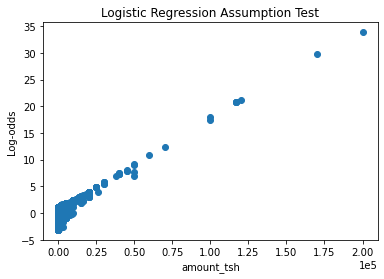

In [25]:
#Grab probabilities and calculate log odds
pred = logreg.predict_proba(X_train)[:, 0]
log_odds = np.log(pred / (1 - pred))
#Plot log odds versus continuous variable to check for linearity
plt.scatter(x = X_train['amount_tsh'].values, y = log_odds)
plt.title("Logistic Regression Assumption Test")
plt.xlabel("amount_tsh")
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ylabel("Log-odds")
plt.show();

While the precision for the logistic regression model is worse, coming in at 0.75 for both the training and validation sets, this model is less complex and easier to implement than the decision tree. It does not violate the assumptions of logistic regression, nor does it seem to overfit. Therefore, it is a more viable and useable model for the NGO to potentially implement. 

Finally, while a Random Forest Classifier model would be more complex, we were interested in determining if we could get a sizeable increase in precision, based on the four aforementioned most important features, to balance the first model and the second model.

#### Random Forest Classifier

In [13]:
#Build pipeline for random forest
ensemble = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(random_state = 42))
])

#Fit the model
ensemble.fit(X_train, y_train)
#Score model based on precision and accuracy
y_pred = ensemble.predict(X_train)
print("Training Precision: " + str(precision_score(y_train, y_pred)))
print("Training Accuracy:", ensemble.score(X_train, y_train))
scores = cross_validate(ensemble, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Precision:" + str(np.mean(scores['test_pre'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Precision: 0.7629366710255931
Training Accuracy: 0.6748859716144567
Validation Precision:0.7493624263722175
Validation Accuracy:0.6688198285364692


This is only a slight increase in precision for the training score, compared to the first model, but there is also a decrease in the validation score, indicating potential overfitting. In an effort to potentially increase the performance of this model, we tuned its parameters using a gridsearch.

In [16]:
#Creates parameters to test
params = {
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__max_depth': [None, 50, 100],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__n_estimators': [100, 200, 300]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(ensemble, param_grid = params, scoring = scoring, cv = 5, refit = 'pre')
search.fit(X_train, y_train)
search.best_params_

{'rfc__criterion': 'entropy',
 'rfc__max_depth': None,
 'rfc__min_samples_split': 5,
 'rfc__n_estimators': 300}

In [17]:
ensemble_tuned = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(criterion = 'entropy', min_samples_split = 5, 
                                   n_estimators = 300, random_state = 42))
])

#Fit and print precision for tuned model
ensemble_tuned.fit(X_train, y_train)
y_pred = ensemble_tuned.predict(X_train)
print("Training Precision: " + str(precision_score(y_train, y_pred)))
print("Training Accuracy:", ensemble_tuned.score(X_train, y_train))
scores = cross_validate(ensemble_tuned, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Precision:" + str(np.mean(scores['test_pre'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Precision: 0.7627276973376926
Training Accuracy: 0.6747702067560372
Validation Precision:0.7500577606668261
Validation Accuracy:0.6689818977305354


Despite tuning the model, the performance is still only marginally better than the logistic regression model, as well as being more computationally stressful and performing worse on the validation scores. As a result, the final model we decided to go with was the logistic regression model with four features.

In [18]:
from xgboost import XGBClassifier

#Build pipeline for random forest
xgboost = Pipeline(steps=[
    ('trans', trans),
    ('xgb', XGBClassifier(random_state = 42))
])

#Fit the model
xgboost.fit(X_train, y_train)
#Score model based on precision and accuracy
y_pred = xgboost.predict(X_train)
print("Training Precision: " + str(precision_score(y_train, y_pred)))
print("Training Accuracy:", xgboost.score(X_train, y_train))
scores = cross_validate(xgboost, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Precision:" + str(np.mean(scores['test_pre'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Precision: 0.7669172932330827
Training Accuracy: 0.6727558982195365
Validation Precision:0.7518590579039783
Validation Accuracy:0.6681021073176208


In [20]:
params = {
    'xgb__learning_rate': [0.2, 0.25],
    'xgb__subsample': [0.7, 0.8],
    'xgb__n_estimators': [300, 400]
}

search = GridSearchCV(xgboost, param_grid = params, scoring = scoring, cv = 5, refit = 'pre')
search.fit(X_train, y_train)
search.best_params_

{'xgb__learning_rate': 0.25, 'xgb__n_estimators': 300, 'xgb__subsample': 0.7}

In [21]:
from xgboost import XGBClassifier

#Build pipeline for random forest
xgboost_tune = Pipeline(steps=[
    ('trans', trans),
    ('xgb', XGBClassifier(learning_rate = .25, n_estimators = 300, subsample = .7, random_state = 42))
])

#Fit the model
xgboost_tune.fit(X_train, y_train)
#Score model based on precision and accuracy
y_pred = xgboost_tune.predict(X_train)
print("Training Precision: " + str(precision_score(y_train, y_pred)))
print("Training Accuracy:", xgboost_tune.score(X_train, y_train))
scores = cross_validate(xgboost_tune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Precision:" + str(np.mean(scores['test_pre'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Precision: 0.764422622981777
Training Accuracy: 0.6742145354356232
Validation Precision:0.7513556283387253
Validation Accuracy:0.6689819084509928


## Evaluation
---
To reiterate from earlier, we have been using precision as our metric; we want to avoid false positives. In this case, false positives are wells that we identify as needing attention when they are actually fully functional, as this would waste resources for the NGO. As a result, the 75% precise logistic regression was our final model. While this is less than the precision of the original decision tree, this model is less computationally strenuous and therefore comparatively easier for the NGO to implement. Similarly, the model does not seem to be overfitting as the scores for both precision and accuracy of the model are close for both the training and validation sets. The assumptions for the logistic regression model are also met, meaning it is a workable model.

Training Accuracy:0.643791530642958
Validation Accuracy:0.6445323536836469


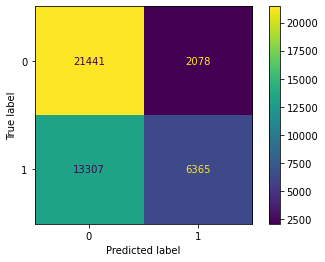

In [32]:
print("Training Accuracy:" + str(logreg.score(X_train, y_train)))
scores = np.mean(cross_val_score(logreg, X_train, y_train, cv=5))
print("Validation Accuracy:" + str(scores))

#Plots confusion matric for test data
preds = logreg.predict(X_train)
cm = confusion_matrix(y_train, preds)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

While the logistic regression model is worse than the first decision tree model, it outperforms the baseline model which had an accuracy of 54% and a precision of 0, indicating it is still worthwhile to use. Furthermore, it still performs well on the test set, with a precision of 0.73 and accuracy of 0.64, both similar to the training set.

Test Recall: 0.3290945304121342
Test Accuracy: 0.642703340973814


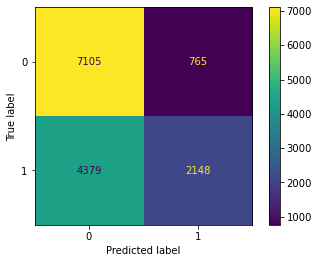

In [33]:
#Test results for final model
preds = logreg.predict(X_test)
print("Test Recall:", precision_score(preds, y_test))
print("Test Accuracy:", logreg.score(X_test, y_test))

#Plts confusion matric for test data
cm = confusion_matrix(y_test, preds)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

Therefore, the logistic regression model is the one we would put forward as out official model for the NGO. While the precision could be improved, making it a more reliable model, it still operates better than the baseline and meets assumptions, while not seeming to overfit, thereby making it applicable to actual data the NGO would be interested in. Through using this model, the NGO could help identify wells in need of repair or replacement and better allocate their resources without wasting time checking up on functional wells.

## Conclusions
---
Overall, we would recommend the NGO consider using this model to help them predict which wells to focus their resources on. We would also recommend that if they have any interest in lobbying for better well construction in the future, they focus in on the total static head of the well, the installer, extraction type, and if the well has a government permit, as these were the most important features in predicting well failure. 

One drawback of this model is that it's built using amount_tsh, which is one of the columns with unclear zeroes representing possible nulls. Therefore to improve the model, we could get more accurate data for this column to see how it impacts the model.

Furthermore these data are outdated and contains records that date all the way back to 2003. Between then and now, there could have been changes in the way wells are constructed or maintained that would impact our predictions, but we lack the data needed to see this, so that would be another future improvement we could work on.

Knowing that NGOs often work under tight budget constraints, we would also love to model cost (well parts, replacement, transportation, etc) to help reduce risk of the organization. 

Finally, we would also like to partner with the NGO in disseminating educational materials and instruction on well maintenance, to impower local communities to increase the sustainability of these improved water sources. 